[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Gaussian Probabilities

In [1]:
#format the book
%matplotlib notebook
from __future__ import division, print_function
from book_format import load_style
load_style()

## Introduction

The last chapter ended by discussing some of the drawbacks of the Discrete Bayesian filter. For many tracking and filtering problems our desire is to have a filter that is *unimodal* and *continuous*. That is, we want to model our system using floating point math (continuous) and to have only one belief represented (unimodal). For example, we want to say an aircraft is at (12.34, -95.54, 2389.5) where that is latitude, longitude, and altitude. We do not want our filter to tell us "it might be at (1.65, -78.01, 2100.45) or it might be at (34.36, -98.23, 2543.79)." That doesn't match our physical intuition of how the world works, and as we discussed, it can be prohibitively expensive to compute the multimodal case. And, of course, multiple position estimates makes navigating impossible.

We desire a unimodal, continuous way to represent probabilities that models how the real world works, and that is computationally efficient to calculate. As you might guess from the chapter name, Gaussian distributions provide all of these features.

## Mean, Variance, and Standard Deviations

### Random Variables


Each time you roll a die the *outcome* will be between 1 and 6. If we rolled a fair die a million times we'd expect to get 1 1/6 of the time. Thus we say the *probability*, or *odds* of the outcome 1 is 1/6. Likewise, if I asked you the chance of 1 being the result of the next roll you'd reply 1/6.  

This combination of values and associated probabilities is called a [*random variable*](https://en.wikipedia.org/wiki/Random_variable). *Random* does not mean the process is nondeterministic, only that we lack information. The result of a die toss is deterministic, but we lack enough information to compute the result. We don't know what will happen, except probabilistically.

While we are defining things, the range of values is called the [*sample space*](https://en.wikipedia.org/wiki/Sample_space). For a die the sample space is {1, 2, 3, 4, 5, 6}. For a coin the sample space is {H, T}. *Space* is a mathematical term which means a set with structure. The sample space for the die is a subset of the natural numbers in the range of 1 to 6.

Another example of a random variable is the heights of students in a university. Here the sample space is a range of values in the real numbers between two limits defined by biology.

Random variables such as coin tosses and die rolls are *discrete random variables*. This means their sample space is represented by either a finite number of values or a countably infinite number of values such as the natural numbers. Heights of humans are called *continuous random variables* since they can take on any real value between two limits.

Do not confuse the *measurement* of the random variable with the actual value. If we can only measure the height of a person to 0.1 meters we would only record values from 0.1, 0.2, 0.3...2.7, yielding 27 discrete choices. Nonetheless a person's height can vary between any arbitrary real value between those ranges, and so height is a continuous random variable. 

In statistics capital letters are used for random variables, usually from the latter half of the alphabet. So, we might say that $X$ is the random variable representing the die toss, or $Y$ are the heights of the students in the freshmen poetry class. In later chapters we will follow the convention of using  lower case for vectors, and upper case for matrices. Unfortunately these conventions clash, and you will have to determine which an author is using from context. 

## Probability Distribution


The [*probability distribution*](https://en.wikipedia.org/wiki/Probability_distribution) gives the probability for the random variable to take any value in a sample space. For example, for a fair six sided die we might say:

|Value|Probability|
|-----|-----------|
|1|1/6|
|2|1/6|
|3|1/6|
|4|1/6|
|5|1/6|
|6|1/6|

Some sources call this the *probability function*. Using ordinary function notation, we would write:

$$P(X{=}4) = f(4) = \frac{1}{6}$$

This states that the probability of the die landing on 4 is $\frac{1}{6}$. $P(X{=}x_k)$ is notation for "the probability of $X$ being $x_k$. Some texts use $Pr$ or $Prob$ instead of $P$.


Another example is a fair coin. It has the sample space {H, T}. The coin is fair, so the probability for heads (H) is 50%, and the probability for tails (T) is 50%. We write this as

$$\begin{gathered}P(X{=}H) = 0.5\\P(X{=}T)=0.5\end{gathered}$$

Sample spaces are not unique. One sample space for a die is {1, 2, 3, 4, 5, 6}. Another valid sample space would be {even, odd}. Another might be {dots in all corners, not dots in all corners}. A sample space is valid so long as it covers all possibilities, and any single event is described by only one element.  {even, 1, 3, 4, 5} is not a valid sample space for a die since a value of 4 is matched both by 'even' and '4'.

The probabilities for all values of a *discrete random value* is known as the *discrete probability distribution* and the probabilities for all values of a *continuous random value* is known as the *continuous probability distribution*.

To be a probability distribution the probability of each value $x_i$ must be $x_i \ge 0$, since no probability can be less than zero. Secondly, the sum of the probabilities for all values must equal one. This should be intuitively clear for a coin toss: if the odds of getting heads is 70%, then the odds of getting tails must be 30%. We formulize this requirement as

$$\sum\limits_u P(X{=}u)= 1$$

for discrete distributions, and as 

$$\int P(X{=}u) \,du= 1$$

for continuous distributions.

### The Mean, Median, and Mode of a Random Variable

Given a set of data we often want to know a representative or average value for that set. There are many measures for this, and the concept is called a [*measure of central tendency*](https://en.wikipedia.org/wiki/Central_tendency). For example we will want to know the *average* height of the students. We all know how to find the average, but let me belabor the point so I can introduce more formal notation and terminology. Another word for average is the *mean*. We compute the mean by summing the values and dividing by the number of values. If the heights of the students in meters is 

$$X = \{1.8, 2.0, 1.7, 1.9, 1.6\}$$

we compute the mean as

$$\mu = \frac{1.8 + 2.0 + 1.7 + 1.9 + 1.6}{5} = 1.8$$

It is traditional to use the symbol $\mu$ (mu) to denote the mean.

We can formalize this computation with the equation

$$ \mu = \frac{1}{n}\sum^n_{i=1} x_i$$

NumPy provides `numpy.mean()` for computing the mean.

In [2]:
import numpy as np
x = [1.85, 2.0, 1.7, 1.9, 1.6]
print(np.mean(x))

1.81


The *mode* of a set of numbers is the number that occurs most often. If only one number occurs most often we say it is a *unimodal* set, and if two or more numbers occur the most with equal frequency than te set is *multimodal*. For example the set {1, 2, 2, 2, 3, 4, 4, 4} has modes 2 and 4, which is multimodal, and the set {5, 7, 7, 13} has the mode 7, and so it is unimodal. We will not be computing the mode in this manner in this book, but we do use the concepts of unimodal and multimodal in a more general sense. For example, in the **Discrete Bayes** chapter we talked about our belief in the dog's position as a *multimodal distribution* because we assigned different probabilities to different positions.

Finally, the *median* of a set of numbers is the middle point of the set so that half the values are below the median and half are above the median. Here, above and below is in relation to the set being sorted.  If the set contains an even number of values then the two middle numbers are averaged together.

Numpy provides `numpy.median()` to compute the median. As you can see the median of {1.85, 2.0, 1.7, 1.9, 1.6} is 1.85, because 1.85 is the third element of this set after being sorted.

In [3]:
print(np.median(x))

1.85


## Expected Value of a Random Variable

The [*expected value*](https://en.wikipedia.org/wiki/Expected_value) of a random variable is the average value it would have if we took an infinite number of samples of it and then averaged those samples together. Let's say we have $x=[1,3,5]$ and each value is equally probable. What would we *expect* $x$ to have, on average?

It would be the average of 1, 3, and 5, of course, which is 3. That should make sense; we would expect equal numbers of 1, 3, and 5 to occur, so $(1+3+5)/3=3$ is clearly the average of that infinite series of samples. In other words, here the expected value is the *mean* of the sample space.

Now suppose that each value has a different probability of happening. Say 1 has an 80% chance of occurring, 3 has an 15% chance, and 5 has only a 5% chance. In this case we compute the expected value by multiplying each value of $x$ by the percent chance of it occurring, and summing the result. For this case we could compute

$$\mathbb E[X] = (1)(0.8) + (3)(0.15) + (5)(0.05) = 1.5$$

Here I have introduced the notation $\mathbb E[X]$ for the expected value of $x$. Some texts use $E(x)$. The value 1.5 for $x$ makes intuitive sense because $x$ is far more likely to be 1 than 3 or 5, and 3 is more likely than 5 as well.

We can formalize this by letting $x_i$ be the $i^{th}$ value of $X$, and $p_i$ be the probability of its occurrence. This gives us

$$\mathbb E[X] = \sum_{i=1}^n p_ix_i$$

A trivial bit of algebra shows that if the probabilities are all equal, the expected value is the same as the mean:

$$\mathbb E[X] = \sum_{i=1}^n p_ix_i = \sum_{i=1}^n \frac{1}{n}x_i = \mu_x$$

If $x$ is continuous we substitute the sum for an integral, like so

$$\mathbb E[X] = \int_{-\infty}^\infty x\, f(x) \,dx$$

where $f(x)$ is the probability distribution function of $x$. We won't be using this equation yet, but we will be using it in the next chapter.

### Variance of a Random Variable

The computation above tells us the average height of the students, but it doesn't tell us everything we might want to know. For example, suppose we have three classes of students, which we label $X$, $Y$, and $Z$, with these heights:

In [4]:
X = [1.8, 2.0, 1.7, 1.9, 1.6]
Y = [2.2, 1.5, 2.3, 1.7, 1.3]
Z = [1.8, 1.8, 1.8, 1.8, 1.8]

Using NumPy we see that the mean height of each class is the same. 

In [5]:
print(np.mean(X))
print(np.mean(Y))
print(np.mean(Z))

1.8
1.8
1.8


The mean of each class is 1.8 meters, but notice that there is a much greater amount of variation in the heights in the second class than in the first class, and that there is no variation at all in the third class.

The mean tells us something about the data, but not the whole story. We want to be able to specify how much *variation* there is between the heights of the students. You can imagine a number of reasons for this. Perhaps a school district needs to order 5,000 desks, and they want to be sure they buy sizes that accommodate the range of heights of the students. 

Statistics has formalized this concept of measuring variation into the notion of [*standard deviation*](https://en.wikipedia.org/wiki/Standard_deviation) and [*variance*](https://en.wikipedia.org/wiki/Variance). The equation for computing the variance is

$$\mathit{VAR}(X) = E[(X - \mu)^2]$$

Ignoring the squared terms for a moment, you can see that the variance is the *expected value* for how much the sample space ($X$) varies from the mean (squared, of course). We have the formula for the expected value $E[X] = \sum\limits_{i=1}^n p_ix_i$, and we will assume that any height is equally probable, so we can substitute that into the equation above to get

$$\mathit{VAR}(X) = \frac{1}{n}\sum_{i=1}^n (x_i - \mu)^2$$
 
Let's compute the variance of the three classes to see what values we get and to become familiar with this concept.

The mean of $X$ is 1.8 ($\mu_x = 1.8$) so we compute

$$ 
\begin{aligned}
\mathit{VAR}(X) &=\frac{(1.8-1.8)^2 + (2-1.8)^2 + (1.7-1.8)^2 + (1.9-1.8)^2 + (1.6-1.8)^2} {5} \\
&= \frac{0 + 0.04 + 0.01 + 0.01 + 0.04}{5} \\
\mathit{VAR}(X)&= 0.02 \, m^2
\end{aligned}$$

NumPy provides the function `var()` to compute the variance:

In [6]:
print(np.var(X), "meters squared")

0.02 meters squared


This is perhaps a bit hard to interpret. Heights are in meters, yet the variance is meters squared. Thus we have a more commonly used measure, the *standard deviation*, which is defined as the square root of the variance:

$$\sigma = \sqrt{\mathit{VAR}(X)}=\sqrt{\frac{1}{n}\sum_{i=1}^n(x_i - \mu)^2}$$

It is typical to use $\sigma$ for the *standard deviation* and $\sigma^2$ for the *variance*. In most of this book I will be using $\sigma^2$ instead of $\mathit{VAR}(X)$ for the variance; they symbolize the same thing.

For the first class we compute the standard deviation with

$$ 
\begin{aligned}
\sigma_x &=\sqrt{\frac{(1.8-1.8)^2 + (2-1.8)^2 + (1.7-1.8)^2 + (1.9-1.8)^2 + (1.6-1.8)^2} {5}} \\
&= \sqrt{\frac{0 + 0.04 + 0.01 + 0.01 + 0.04}{5}} \\
\sigma_x&= 0.1414
\end{aligned}$$

We can verify this computation with the NumPy method `numpy.std()` which computes the standard deviation. 'std' is a common abbreviation for standard deviation.

In [7]:
print('std {:.4f}'.format(np.std(X)))
print('var {:.4f}'.format(np.std(X)**2))

std 0.1414
var 0.0200


And, of course, $0.1414^2 = 0.02$, which agrees with our earlier computation of the variance.

What does the standard deviation signify? It tells us how much the heights vary amongst themselves. "How much" is not a mathematical term. We will be able to define it much more precisely once we introduce the concept of a Gaussian in the next section. For now I'll say that for many things 68% of all values lie within one standard deviation of the mean. In other words we can conclude that for a random class 68% of the students will have heights between 1.66 (1.8-0.1414) meters and 1.94 (1.8+0.1414) meters. 

We can view this in a plot:

<IPython.core.display.Javascript object>


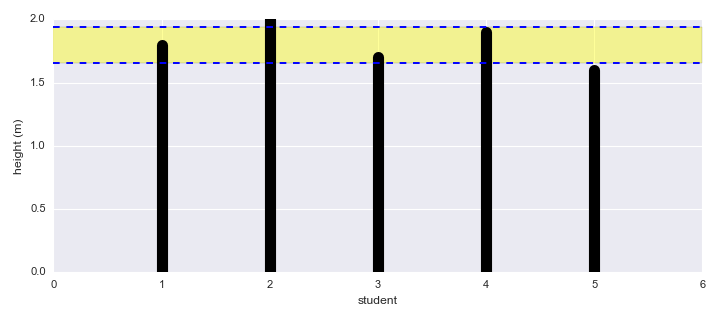

In [8]:
from book_format import set_figsize, figsize
from code.book_plots import interactive_plot
from code.gaussian_internal import plot_height_std
import matplotlib.pyplot as plt


with interactive_plot():
    plot_height_std(X)

For only 5 students we obviously will not get exactly 68% within one standard deviation. We do see that 3 out of 5 students are within $\pm1\sigma$, or 60%, which is as close as you can get to 68% with only 5 samples. I haven't yet introduced enough math or Python for you to fully understand the next bit of code, but let's look at the results for a class with 100 students.

>  We write one standard deviation as  $1\sigma$, which is pronounced "one standard deviation", not "one sigma". Two standard deviations is $2\sigma$, and so on.

<IPython.core.display.Javascript object>


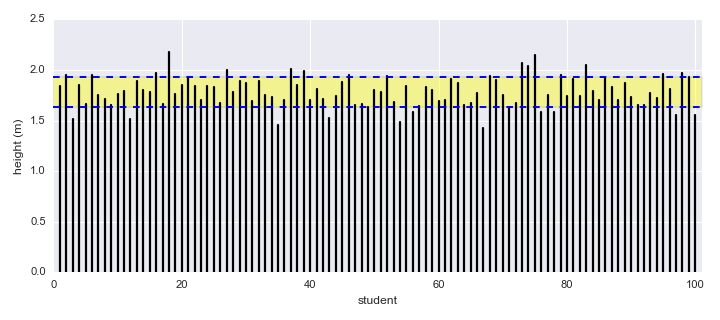

mean = 1.784
std  = 0.148


In [9]:
from numpy.random import randn
data = [1.8 + .1414*randn() for i in range(100)]

with interactive_plot():
    plot_height_std(data, lw=2)

print('mean = {:.3f}'.format(np.mean(data)))
print('std  = {:.3f}'.format(np.std(data)))

We can see by eye that roughly 68% of the heights lie within $\pm1\sigma$ of the mean 1.8.

We'll discuss this in greater depth soon. For now let's compute the standard deviation for 

$$Y = [2.2, 1.5, 2.3, 1.7, 1.3]$$

The mean of $Y$ is $\mu=1.8$ m, so 

$$ 
\begin{aligned}
\sigma_y &=\sqrt{\frac{(2.2-1.8)^2 + (1.5-1.8)^2 + (2.3-1.8)^2 + (1.7-1.8)^2 + (1.3-1.8)^2} {5}} \\
&= \sqrt{0.152} = 0.39 \ m
\end{aligned}$$

We will verify that with NumPy with

In [10]:
print('std of Y is {:.4f} m'.format(np.std(Y)))

std of Y is 0.3899 m


This corresponds with what we would expect. There is more variation in the heights for $Y$, and the standard deviation is larger.

Finally, let's compute the standard deviation for $Z$. There is no variation in the values, so we would expect the standard deviation to be zero. We show this to be true with

$$ 
\begin{aligned}
\sigma_z &=\sqrt{\frac{(1.8-1.8)^2 + (1.8-1.8)^2 + (1.8-1.8)^2 + (1.8-1.8)^2 + (1.8-1.8)^2} {5}} \\
&= \sqrt{\frac{0+0+0+0+0}{5}} \\
\sigma_z&= 0.0 \ m
\end{aligned}$$

In [11]:
print(np.std(Z))

0.0


Before we continue I need to point out that I'm ignoring that on average  men are taller than women. In general the height variance of a class that contains only men or women will be smaller than a class with both sexes. This is true for other factors as well. Well nourished children are taller than malnourished children. Scandinavians are taller than Italians. When designing experiments statisticians need to take these factors into account. 

I suggested we might be performing this analysis to order desks for a school district.  For each age group there are likely to be two different means - one clustered around the mean height of the females, and a second mean clustered around the mean heights of the males. The mean of the entire class will be somewhere between the two. If we bought desks for the mean of all students we are likely to end up with desks that fit neither the males or females in the school! 

It's too early to understand why, but we will not normally be faced with these problems in this book.  Consult any standard probability text if you need to learn techniques to deal with these issues.

### Why the Square of the Differences

Why are we taking the *square* of the differences for the variance? I could go into a lot of math, but let's look at this in a simple way. Here is a chart of the values of $X$ plotted against the mean for $X=[3,-3,3,-3]$

<IPython.core.display.Javascript object>


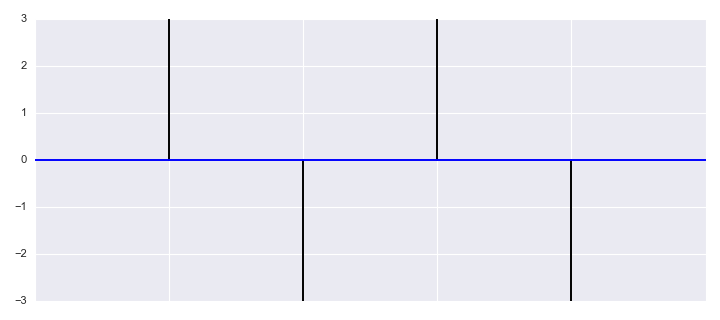

In [12]:
with interactive_plot():
    X = [3, -3, 3, -3]
    mean = np.average(X)
    for i in range(len(X)):
        plt.plot([i ,i], [mean, X[i]], color='k')
    plt.axhline(mean)
    plt.xlim(-1, len(X))
    plt.tick_params(axis='x', labelbottom='off')

If we didn't take the square of the differences the signs would cancel everything out:

$$\frac{(3-0) + (-3-0) + (3-0) + (-3-0)}{4} = 0$$

This is clearly incorrect, as there is more than 0 variance in the data. 

Maybe we can use the absolute value? We can see by inspection that the result is $12/4=3$ which is certainly correct — each value varies by 3 from the mean. But what if we have $Y=[6, -2, -3, 1]$? In this case we get $12/4=3$. $Y$ is clearly more spread out than $X$, but the computation yields the same variance. If we use the correct formula we get a variance of 3.5 for $Y$, which reflects its larger variation.

This is not a proof of correctness. Indeed, Carl Friedrich Gauss, the inventor of the technique, recognized that is is somewhat arbitrary. If there are outliers then squaring the difference gives disproportionate weight to that term. For example, let's see what happens if we have $X = [1,-1,1,-2,3,2,100]$.

In [13]:
X = [1, -1, 1, -2, 3, 2, 100]
print('Variance of X = {:.2f}'.format(np.var(X)))

Variance of X = 1210.69


Is this "correct"? You tell me. Without the outlier of 100 we get $\sigma^2=2.89$, which accurately reflects how $X$ is varying absent the outlier. The one outlier swamps the computation. I will not continue down this path; if you are interested you might want to look at the work that James Berger has done on this problem, in a field called *Bayesian robustness*, or the excellent publications on *robust statistics* by Peter J. Huber [3].

## Gaussians

We are now ready to learn about [Gaussians](https://en.wikipedia.org/wiki/Gaussian_function). Let's remind ourselves of the motivation for this chapter.

> We desire a unimodal, continuous way to represent probabilities that models how the real world works, and that is computationally efficient to calculate.

Let's look at a graph of a Gaussian distribution to get a sense of what we are talking about.

<IPython.core.display.Javascript object>


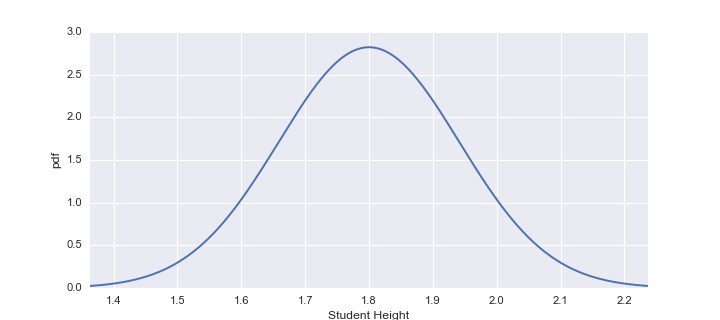

In [14]:
from filterpy.stats import plot_gaussian_pdf
plt.figure()
ax = plot_gaussian_pdf(mean=1.8, variance=0.1414**2, 
                  xlabel='Student Height', ylabel='pdf')

This curve is a [*probability density function*](https://en.wikipedia.org/wiki/Probability_density_function) or *pdf* for short. It shows the relative likelihood  for the random variable to take on a value. In the chart above, a student is somewhat more likely to have a height near 1.8 m than 1.7 m, and far more likely to have a height of 1.9 m vs 1.1 m.

> I explain how to plot Gaussians, and much more, in the Notebook *Computing_and_Plotting_PDFs* in the 
Supporting_Notebooks folder. You can read it online [here](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/Supporting_Notebooks/Computing_and_plotting_PDFs.ipynb) [1].

This may be recognizable to you as a 'bell curve'. This curve is ubiquitous because under real world conditions many observations are distributed in such a manner. In fact, this is the  curve for the student heights given earlier. I will not use the term 'bell curve' to refer to a Gaussian because many probability distributions have a similar bell curve shape. Non-mathematical sources might not be as precise, so be judicious in what you conclude when you see the term used without definition.

This curve is not unique to heights — a vast amount of natural phenomena exhibits this sort of distribution, including the sensors that we use in filtering problems. As we will see, it also has all the attributes that we are looking for — it represents a unimodal belief or value as a probability, it is continuous, and it is computationally efficient. We will soon discover that it also has other desirable qualities which we may not realize we desire.

To further motivate you, recall the shapes of the probability distributions in the *Discrete Bayes* chapter. They were not perfect Gaussian curves, but they were similar, as in the plot below. We will be using Gaussians to replace the discrete probabilities used in that chapter!

<IPython.core.display.Javascript object>


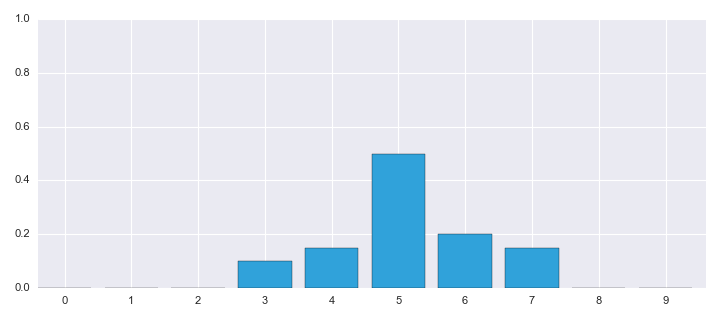

In [15]:
import code.book_plots as book_plots
belief = [ 0.,0., 0., 0.1, 0.15, 0.5, 0.2, .15, 0, 0]
with interactive_plot():
    book_plots.bar_plot(belief)

## Nomenclature

A bit of nomenclature before we continue - this chart depicts the *probability density* of a *random variable* having any value between ($-\infty..\infty)$. What does that mean? Imagine we take an infinite number of infinitely precise measurements of the speed of automobiles on a section of highway. We could then plot the results by showing the relative number of cars going past at any given speed. If the average was 120 kph, it might look like this:

<IPython.core.display.Javascript object>


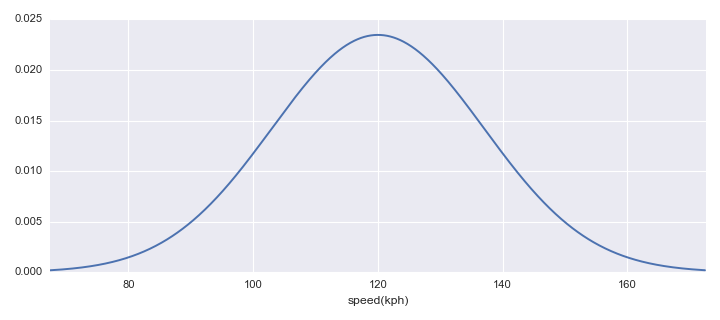

In [16]:
with interactive_plot():
    ax = plot_gaussian_pdf(mean=120, variance=17**2, xlabel='speed(kph)')

The y-axis depicts the *probability density* — the relative amount of cars that are going the speed at the corresponding x-axis.

You may object that human heights or automobile speeds cannot be less than zero, let alone $-\infty$ or $\infty$. This is true, but this is a common limitation of mathematical modeling. “The map is not the territory” is a common expression, and it is true for Bayesian filtering and statistics. The Gaussian distribution above models the distribution of the measured automobile speeds, but being a model it is necessarily imperfect. The difference between model and reality will come up again and again in these filters. Gaussians are used in many branches of mathematics, not because they perfectly model reality, but because they are easier to use than any other relatively accurate choice. However, even in this book Gaussians will fail to model reality, forcing us to use computationally expensive alternatives. 

You will see these distributions called *Gaussian distributions* or *normal distributions*.  *Gaussian* and *normal* both mean the same thing in this context, and are used interchangeably. I will use both throughout this book as different sources will use either term, and I want you to be used to seeing both. Finally, as in this paragraph, it is typical to shorten the name and talk about a *Gaussian* or *normal* — these are both typical shortcut names for the *Gaussian distribution*. 

## Gaussian Distributions

Let's explore how Gaussians work. A Gaussian is a *continuous probability distribution* that is completely described with two parameters, the mean ($\mu$) and the variance ($\sigma^2$). It is defined as:

$$ 
f(x, \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\big [{-\frac{(x-\mu)^2}{2\sigma^2} }\big ]
$$

$\exp[x]$ is notation for $e^x$.

<p> Don't be dissuaded by the equation if you haven't seen it before; you will not need to memorize or manipulate it. The computation of this function is stored in `stats.py` with the function `gaussian(x, mean, var)`.

> **Optional:** Let's remind ourselves how to look at a function stored in a file by using the *%load* magic. If you type *%load -s gaussian stats.py* into a code cell and then press CTRL-Enter, the notebook will create a new input cell and load the function into it.

```python
%load -s gaussian stats.py

def gaussian(x, mean, var):
    """returns normal distribution for x given a 
    gaussian with the specified mean and variance. 
    """
    return (np.exp((-0.5*(np.asarray(x)-mean)**2)/var) /
            math.sqrt(2*math.pi*var))

```

<p><p><p><p>We will plot a Gaussian with a mean of 22 $(\mu=22)$, with a variance of 4 $(\sigma^2=4)$, and then discuss what this means. 

<IPython.core.display.Javascript object>


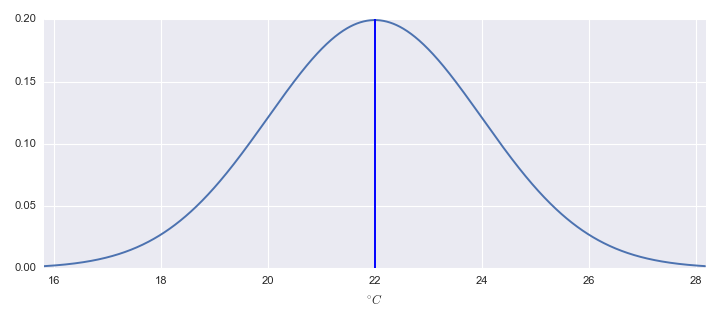

In [17]:
from filterpy.stats import gaussian, norm_cdf

with interactive_plot():
    ax = plot_gaussian_pdf(22, 4, mean_line=True, xlabel='$^{\circ}C$')

What does this curve *mean*? Assume we have a thermometer which reads 22°C. No thermometer is perfectly accurate, and so we expect that each reading will be slightly off the actual value. However, a theorem called  [*Central Limit Theorem*](https://en.wikipedia.org/wiki/Central_limit_theorem) states that if we make many measurements that the measurements will be normally distributed. When we look at this chart we can "sort of" think of it as representing the probability of the thermometer reading a particular value given the actual temperature of 22°C. 

Recall that a Gaussian distribution is *continuous*. Think of an infinitely long straight line - what is the probability that a point you pick randomly is at 2. Clearly 0%, as there is an infinite number of choices to choose from. The same is true for normal distributions; in the graph above the probability of being *exactly* 2°C is 0% because there are an infinite number of values the reading can take.

What is this curve? It is something we call the *probability density function.* The area under the curve at any region gives you the probability of those values. So, for example, if you compute the area under the curve between 20 and 22 the resulting area will be the probability of the temperature reading being between those two temperatures. 

We can think of this in Bayesian terms or frequentist terms. As a Bayesian, if the thermometer reads exactly 22°C, then our belief is described by the curve - our belief that the actual (system) temperature is near 22 is very high, and our belief that the actual temperature is near 18 is very low. As a frequentist we would say that if we took 1 billion temperature measurements of a system at exactly 22°C, then a histogram of the measurements would look like this curve. 

How do you compute the probability, or area under the curve? You integrate the equation for the Gaussian 

$$ \int^{x_1}_{x_0}  \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}{(x-\mu)^2}/\sigma^2 } dx$$

I wrote `filterpy.stats.norm_cdf` which computes the integral for you. For example, we can compute

In [18]:
print('Probability of range 21.5 to 22.5 is {:.2f}%'.format(
      norm_cdf((21.5, 22.5), 22,4)*100))
print('Probability of range 23.5 to 24.5 is {:.2f}%'.format(
      norm_cdf((23.5, 24.5), 22,4)*100))

Probability of range 21.5 to 22.5 is 19.74%
Probability of range 23.5 to 24.5 is 12.10%


The mean ($\mu$) is what it sounds like — the average of all possible probabilities. Because of the symmetric shape of the curve it is also the tallest part of the curve. The thermometer reads 22°C, so that is what we used for the mean.  

The notation for a normal distribution for a random variable $X$ is $X \sim\ \mathcal{N}(\mu,\sigma^2)$ where $\sim$ means *distributed according to*. This means I can express the temperature reading of our thermometer as

$$\text{temp} \sim \mathcal{N}(22,4)$$

This is an extremely important result. Gaussians allow me to capture an infinite number of possible values with only two numbers! With the values $\mu=22$ and $\sigma^2=4$ I can compute the distribution of measurements for over any range.

> Some sources use $\mathcal N (\mu, \sigma)$ instead of $\mathcal N (\mu, \sigma^2)$. Either is fine, they are both conventions. You need to keep in mind which form is being used if you see a term such as $\mathcal{N}(22,4)$. In this book I always use $\mathcal N (\mu, \sigma^2)$, so $\sigma=2$, $\sigma^2=4$ for this example.

## The Variance and Belief

Since this is a probability density distribution it is required that the area under the curve always equals one. This should be intuitively clear — the area under the curve represents all possible outcomes, *something* happened, and the probability of *something happening* is one, so the density must sum to one. We can prove this ourselves with a bit of code. (If you are mathematically inclined, integrate the Gaussian equation from $-\infty$ to $\infty$)

In [19]:
print(norm_cdf((-1e8, 1e8), mu=0, var=4))

1.0


This leads to an important insight. If the variance is small the curve will be narrow. this is because the variance is a measure of *how much* the samples vary from the mean. To keep the area equal to 1, the curve must also be tall. On the other hand if the variance is large the curve will be wide, and thus it will also have to be short to make the area equal to 1.

Let's look at that graphically:

<IPython.core.display.Javascript object>


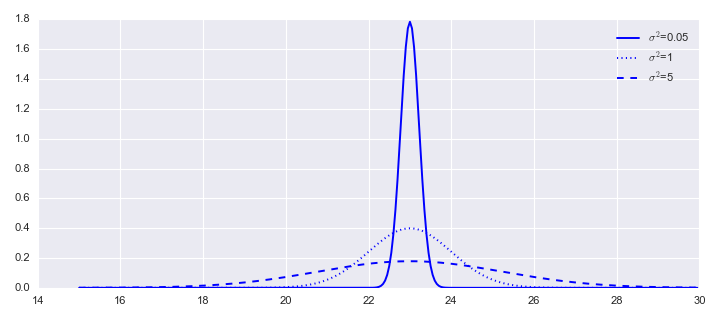

In [20]:
import numpy as np
import matplotlib.pyplot as plt
    
xs = np.arange(15, 30, 0.05)
with interactive_plot():
    plt.plot(xs, gaussian(xs, 23, 0.05), label='$\sigma^2$=0.05', c='b')
    plt.plot(xs, gaussian(xs, 23, 1), label='$\sigma^2$=1', ls=':', c='b')
    plt.plot(xs, gaussian(xs, 23, 5), label='$\sigma^2$=5', ls='--', c='b')
    plt.legend()

What is this telling us? The Gaussian with $\sigma^2=0.05$ is very narrow. It is saying that we believe $x=23$, and that we are very sure about that. In contrast, the Gaussian with $\sigma^2=5$ also believes that $x=23$, but we are much less sure about that. Our believe that $x=23$ is lower, and so our belief about the likely possible values for $x$ is spread out — we think it is quite likely that $x=20$ or $x=26$, for example. $\sigma^2=0.05$ has almost completely eliminated $22$ or $24$ as possible values, whereas $\sigma^2=5$ considers them nearly as likely as $23$.

If we think back to the thermometer, we can consider these three curves as representing the readings from three different thermometers. The curve for $\sigma^2=0.05$ represents a very accurate thermometer, and curve for $\sigma^2=5$ represents a fairly inaccurate one. Note the very powerful property the Gaussian distribution affords us — we can entirely represent both the reading and the error of a thermometer with only two numbers — the mean and the variance.

An equivalent formation for a Gaussian is $\mathcal{N}(\mu,1/\tau)$ where $\mu$ is the *mean* and $\tau$ the *precision*. $1/\tau = \sigma^2$; it is the reciprocal of the variance. While we do not use this formulation in this book, it underscores that the variance is a measure of how precise our data is. A small variance yields large precision — our measurement is very precise. Conversely, a large variance yields low precision — our belief is spread out across a large area. You should become comfortable with thinking about Gaussians in these equivalent forms. In Bayesian terms Gaussians reflect our *belief* about a measurement, they express the *precision* of the measurement, and they express how much *variance* there is in the measurements. These are all different ways of stating the same fact.

I'm getting ahead of myself, but in the next chapters we will use Gaussians to express our belief in things like the estimated position of the object we are tracking, or the accuracy of the sensors we are using.

## The  68-95-99.7 Rule

It is worth spending a few words on standard deviation now. The standard deviation is a measure of how much variation from the mean exists. For Gaussian distributions, 68% of all the data falls within one standard deviation ($\pm1\sigma$) of the mean, 95% falls within two standard deviations ($\pm2\sigma$), and 99.7% within three ($\pm3\sigma$). This is often called the [68-95-99.7 rule](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule). If you were told that the average test score in a class was 71 with a standard deviation of 9.4, you could conclude that 95% of the students received a score between 52.2 and 89.8 if the distribution is normal (that is calculated with $71 \pm (2 * 9.4)$). 

Finally, these are not arbitrary numbers. If the Gaussian for our position is $\mu=22$ meters, then the standard deviation also has units meters. Thus $\sigma=0.2$ implies that 68% of the measurements range from 21.8 to 22.2 meters. Variance is the standard deviation squared, thus $\sigma^2 = .04$ meters$^2$.

The following graph depicts the relationship between the standard deviation and the normal distribution. 

<IPython.core.display.Javascript object>


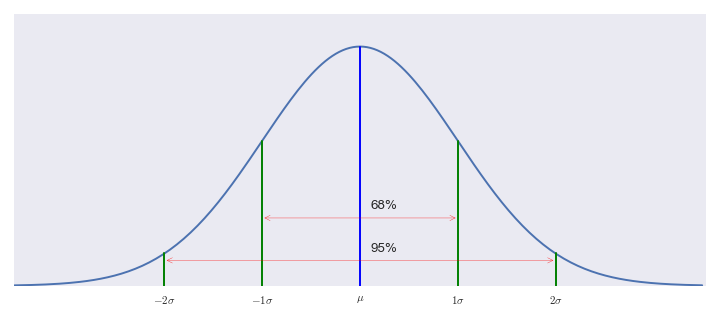

In [21]:
from code.gaussian_internal import display_stddev_plot
with interactive_plot():
    display_stddev_plot()

## Interactive Gaussians

For those that are reading this in a Jupyter Notebook, here is an interactive version of the Gaussian plots. Use the sliders to modify $\mu$ and $\sigma^2$. Adjusting $\mu$ will move the graph to the left and right because you are adjusting the mean, and adjusting $\sigma^2$ will make the bell curve thicker and thinner.

<IPython.core.display.Javascript object>


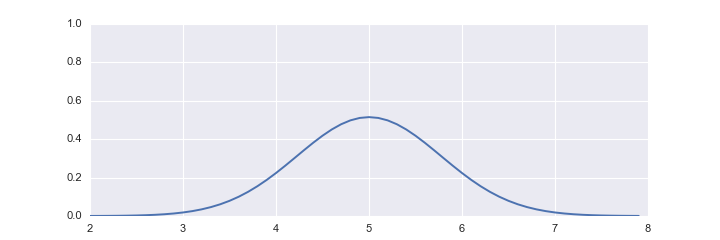

In [22]:
import math
from IPython.html.widgets import interact, interactive, fixed

set_figsize(y=3)
def plt_g(mu,variance):
    plt.figure()
    xs = np.arange(2, 8, 0.1)
    ys = gaussian(xs, mu, variance)
    plt.plot(xs, ys)
    plt.ylim((0, 1))

interact (plt_g, mu=(0., 10), variance = (.2, 1.));

Finally, if you are reading this online, here is an animation of a Gaussian. First, the mean is shifted to the right. Then the mean is centered at $\mu=5$ and the variance is modified.

<img src='animations/04_gaussian_animate.gif'>

## Computational Properties of Gaussians

A remarkable property of Gaussians is that the product of two independent Gaussians is another Gaussian! The sum is not Gaussian, but proportional to a Gaussian.

The discrete Bayes filter works by multiplying and adding probabilities. I'm getting ahead of myself, but the Kalman filter uses Gaussians instead of probabilities, but the rest of the algorithm remains the same. This means we will need to multiply and add Gaussians. 

The Gaussian is a nonlinear function, and typically if you multiply a nonlinear equation with itself you end up with a different equation. For example, the shape of `sin(x)sin(x)` is very different from `sin(x)`. But the result of multiplying two Gaussians is yet another Gaussian. This is a fundamental property, and a key reason why Kalman filters are computationally feasible. Said another way, Kalman filters use Gaussians *because* they are computationally nice. 

The remainder of this section is optional. I will derive the equations for the sum and product of two Gaussians. You will not need to understand this material to understand the rest of the book, so long as you accept the results. 

### Product of Gaussians

The product of two independent Gaussians is given by:

$$\begin{aligned}\mu &=\frac{\sigma_1^2\mu_2 + \sigma_2^2\mu_1}{\sigma_1^2+\sigma_2^2}\\
\sigma^2 &=\frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} 
\end{aligned}$$

You can find this result by multiplying the equation for two Gaussians together and combining terms. The algebra gets messy. I will derive it using Bayes theorem. We can state the problem as: let the prior be $N(\bar\mu, \bar\sigma^2)$, and measurement be $z \propto N(z, \sigma_z^2)$. What is the posterior  x given the measurement z?

Write the posterior as $P(x \mid z)$. Now we can use Bayes Theorem to state

$$P(x \mid z) = \frac{P(z \mid x)P(x)}{P(z)}$$

$P(z)$ is a normalizing constant, so we can create a proportinality

$$P(x \mid z) \propto P(z|x)P(x)$$

Now we subtitute in the equations for the Gaussians, which are

$$P(z \mid x) = \frac{1}{\sqrt{2\pi\sigma_z^2}}\exp \Big[-\frac{(z-x)^2}{2\sigma_z^2}\Big]$$

$$P(x) = \frac{1}{\sqrt{2\pi\bar\sigma^2}}\exp \Big[-\frac{(x-\bar\mu)^2}{2\bar\sigma^2}\Big]$$

We can drop the leading terms, as they are constants, giving us

$$\begin{aligned}
P(x \mid z) &\propto \exp \Big[-\frac{(z-x)^2}{2\sigma_z^2}\Big]\exp \Big[-\frac{(x-\bar\mu)^2}{2\bar\sigma^2}\Big]\\
&\propto \exp \Big[-\frac{(z-x)^2}{2\sigma_z^2}-\frac{(x-\bar\mu)^2}{2\bar\sigma^2}\Big] \\
&\propto \exp \Big[-\frac{1}{2\sigma_z^2\bar\sigma^2}[\bar\sigma^2(z-x)^2-\sigma_z^2(x-\bar\mu)^2]\Big]
\end{aligned}$$

Now we multiply out the squared terms and group in terms of the posterior $x$.

$$\begin{aligned}
P(x \mid z) &\propto \exp \Big[-\frac{1}{2\sigma_z^2\bar\sigma^2}[\bar\sigma^2(z^2 -2xz + x^2) + \sigma_z^2(x^2 - 2x\bar\mu+\bar\mu^2)]\Big ] \\
&\propto \exp \Big[-\frac{1}{2\sigma_z^2\bar\sigma^2}[x^2(\bar\sigma^2+\sigma_z^2)-2x(\sigma_z^2\bar\mu + \bar\sigma^2z) + (\bar\sigma^2z^2+\sigma_z^2\bar\mu^2)]\Big ]
\end{aligned}$$

The last parentheses do not contain the posterior $x$, so it can be treated as a constant and discarded.

$$P(x \mid z) \propto \exp \Big[-\frac{1}{2}\frac{x^2(\bar\sigma^2+\sigma_z^2)-2x(\sigma_z^2\bar\mu + \bar\sigma^2z)}{\sigma_z^2\bar\sigma^2}\Big ]
$$

Divide numerator and denominator by $\bar\sigma^2+\sigma_z^2$ to get

$$P(x \mid z) \propto \exp \Big[-\frac{1}{2}\frac{x^2-2x(\frac{\sigma_z^2\bar\mu + \bar\sigma^2z}{\bar\sigma^2+\sigma_z^2})}{\frac{\sigma_z^2\bar\sigma^2}{\bar\sigma^2+\sigma_z^2}}\Big ]
$$

Proportionality lets us create or delete constants at will, so we can factor this into

$$P(x \mid z) \propto \exp \Big[-\frac{1}{2}\frac{(x-\frac{\sigma_z^2\bar\mu + \bar\sigma^2z}{\bar\sigma^2+\sigma_z^2})^2}{\frac{\sigma_z^2\bar\sigma^2}{\bar\sigma^2+\sigma_z^2}}\Big ]
$$

A Gaussian is

$$N(\mu,\, \sigma^2) \propto \exp\Big [-\frac{1}{2}\frac{(x - \mu)^2}{\sigma^2}\Big ]$$

So we can see that $P(x \mid z)$ has a mean of

$$\mu_\mathtt{posterior} = \frac{\sigma_z^2\bar\mu + \bar\sigma^2z}{\bar\sigma^2+\sigma_z^2}$$

and a variance of
$$
\sigma_\mathtt{posterior} = \frac{\sigma_z^2\bar\sigma^2}{\bar\sigma^2+\sigma_z^2}
$$

I've dropped the constants, and so the result is not a normal, but proportional to one. Bayes theorem normalizes with the $P(z)$ divisor, ensuring that the result is normal. We normalize in the update step of our filters, ensuring the filter estimate is Gaussian.

$$\mathcal N_1 = \| \mathcal N_2\cdot \mathcal N_3\|$$

### Sum of Gaussians

The sum of two Gaussians is given by

$$\begin{gathered}\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
\end{gathered}$$

There are several proofs for this. I will use convolution since we used convolution in the previous chapter for the histograms of probabilities. 

To find the density function of the sum of two Gaussian random variables we sum the density functions of each. They are nonlinear, continuous functions, so we need to compute the sum with an integral. If the random variables $p$ and $z$ (e.g. prior and measurement) are independent we can compute this with

$p(x) = \int\limits_{-\infty}^\infty f_p(x-z)f_z(z)\, dx$

This is the equation for a convolution. Now we just do some math:


$p(x) = \int\limits_{-\infty}^\infty f_2(x-x_1)f_1(x_1)\, dx$

$=  \int\limits_{-\infty}^\infty 
\frac{1}{\sqrt{2\pi}\sigma_z}\exp\left[-\frac{x - z - \mu_z}{2\sigma^2_z}\right]
\frac{1}{\sqrt{2\pi}\sigma_p}\exp\left[-\frac{x - \mu_p}{2\sigma^2_p}\right] \, dx$

$=  \int\limits_{-\infty}^\infty
\frac{1}{\sqrt{2\pi}\sqrt{\sigma_p^2 + \sigma_z^2}} \exp\left[ -\frac{(x - (\mu_p + \mu_z)))^2}{2(\sigma_z^2+\sigma_p^2)}\right]
\frac{1}{\sqrt{2\pi}\frac{\sigma_p\sigma_z}{\sqrt{\sigma_p^2 + \sigma_z^2}}} \exp\left[ -\frac{(x - \frac{\sigma_p^2(x-\mu_z) + \sigma_z^2\mu_p}{}))^2}{2\left(\frac{\sigma_p\sigma_x}{\sqrt{\sigma_z^2+\sigma_p^2}}\right)^2}\right] \, dx$

$= \frac{1}{\sqrt{2\pi}\sqrt{\sigma_p^2 + \sigma_z^2}} \exp\left[ -\frac{(x - (\mu_p + \mu_z)))^2}{2(\sigma_z^2+\sigma_p^2)}\right] \int\limits_{-\infty}^\infty
\frac{1}{\sqrt{2\pi}\frac{\sigma_p\sigma_z}{\sqrt{\sigma_p^2 + \sigma_z^2}}} \exp\left[ -\frac{(x - \frac{\sigma_p^2(x-\mu_z) + \sigma_z^2\mu_p}{}))^2}{2\left(\frac{\sigma_p\sigma_x}{\sqrt{\sigma_z^2+\sigma_p^2}}\right)^2}\right] \, dx$

The expression inside the integral is a normal distribution. The sum of a normal distribution is one, hence the integral is one. This gives us

$$p(x) = \frac{1}{\sqrt{2\pi}\sqrt{\sigma_p^2 + \sigma_z^2}} \exp\left[ -\frac{(x - (\mu_p + \mu_z)))^2}{2(\sigma_z^2+\sigma_p^2)}\right]$$

This is in the form of a normal, where

$$\begin{gathered}\mu_x = \mu_p + \mu_z \\
\sigma_x^2 = \sigma_z^2+\sigma_p^2\, \square\end{gathered}$$

## Computing Probabilities with scipy.stats

In this chapter I used code from [FilterPy](https://github.com/rlabbe/filterpy) to compute and plot Gaussians. I did that to give you a chance to look at the code and see how these functions are implemented.  However, Python comes with "batteries included" as the saying goes, and it comes with a wide range of statistics functions in the module `scipy.stats`. So let's walk through how to use scipy.stats to compute statistics and probabilities.

The `scipy.stats` module contains a number of objects which you can use to compute attributes of various probability distributions. The full documentation for this module is here: http://docs.scipy.org/doc/scipy/reference/stats.html. We will focus on the  norm variable, which implements the normal distribution. Let's look at some code that uses `scipy.stats.norm` to compute a Gaussian, and compare its value to the value returned by the `gaussian()` function from FilterPy.

In [23]:
from scipy.stats import norm
import filterpy.stats
print(norm(2, 3).pdf(1.5))
print(filterpy.stats.gaussian(x=1.5, mean=2, var=3*3))

0.131146572034
0.131146572034


The call `norm(2, 3)` creates what scipy calls a 'frozen' distribution - it creates and returns an object with a mean of 2 and a standard deviation of 3. You can then use this object multiple times to get the probability density of various values, like so:

In [24]:
n23 = norm(2, 3)
print('pdf of 1.5 is       %.4f' % n23.pdf(1.5))
print('pdf of 2.5 is also  %.4f' % n23.pdf(2.5))
print('pdf of 2 is         %.4f' % n23.pdf(2))

pdf of 1.5 is       0.1311
pdf of 2.5 is also  0.1311
pdf of 2 is         0.1330


The documentation for  [scipy.stats.norm](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.normfor) [2] lists many other functions. For example, we can generate $n$ samples from the distribution with the `rvs()` function.

In [25]:
np.set_printoptions(precision=3, linewidth=50)
print(n23.rvs(size=15))

[ 6.7    5.323  3.043  3.361  4.981  3.122  2.841
  0.552  6.937  5.474  0.829  1.398  0.555 -3.212
  1.555]


We can get the [*cumulative distribution function (CDF)*](https://en.wikipedia.org/wiki/Cumulative_distribution_function), which is the probability that a randomly drawn value from the distribution is less than or equal to $x$.

In [26]:
# probability that a random value is less than the mean 2
print(n23.cdf(2))

0.5


We can get various properties of the distribution:

In [27]:
print('variance is', n23.var())
print('standard deviation is', n23.std())
print('mean is', n23.mean())

variance is 9.0
standard deviation is 3.0
mean is 2.0


## Fat Tails

Earlier I mentioned the *central limit theorem*, which states that under certain conditions the arithmetic sum of any independent random variable will be normally distributed, regardless of how the random variables are distributed. This is important to us because nature is full of distributions which are not normal, but when we apply the central limit theorem over large populations we end up with normal distributions. 

However, a key part of the proof is “under certain conditions”. These conditions often do not hold for the physical world. The resulting distributions are called *fat tailed*. Tails is a colloquial term for the far left and right side parts of the curve where the probability density is close to zero.

Let's consider a trivial example. We think of things like test scores as being normally distributed. If you have ever had a professor “grade on a curve” you have been subject to this assumption. But of course test scores cannot follow a normal distribution. This is because the distribution assigns a nonzero probability distribution for *any* value, no matter how far from the mean. So, for example, say your mean is 90 and the standard deviation is 13. The normal distribution assumes that there is a large chance of somebody getting a 90, and a small chance of somebody getting a 40. However, it also implies that there is a tiny chance of somebody getting a grade of -10, or 150. It assigns an infinitesimal chance of getting a score of $-10^{300}$ or $10^{32986}$. The *tails* of a Gaussian distribution are infinitely long.

But for a test we know this is not true. Ignoring extra credit, you cannot get less than 0, or more than 100. Let's plot this range of values using a normal distribution.

<IPython.core.display.Javascript object>


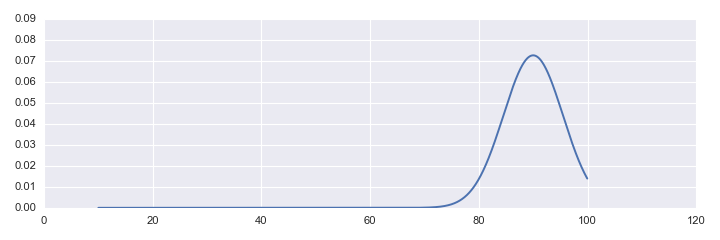

In [28]:
xs = np.arange(10,100, 0.05)
ys = [gaussian(x, 90, 30) for x in xs]
with interactive_plot():
    plt.plot(xs, ys, label='var=0.2')
    plt.xlim((0,120))
    plt.ylim(0, 0.09);

The area under the curve cannot equal 1, so it is not a probability distribution. What actually happens is that more students than predicted by a normal distribution get scores nearer the upper end of the range (for example), and that tail becomes “fat”. Also, the test is probably not able to perfectly distinguish incredibly minute differences in skill in the students, so the distribution to the left of the mean is also probably a bit bunched up in places. The resulting distribution is called a [*fat tail distribution*](https://en.wikipedia.org/wiki/Fat-tailed_distribution). 

Kalman filters use sensors to measure the world. The errors in a sensor's measurements are rarely truly Gaussian. It is far too early to be talking about the difficulties that this presents to the Kalman filter designer. It is worth keeping in the back of your mind the fact that the Kalman filter math is based on an idealized model of the world.  For now I will present a bit of code that I will be using later in the book to form fat tail distributions to simulate various processes and sensors. This distribution is called the [*Student's $t$-distribution*](https://en.wikipedia.org/wiki/Student%27s_t-distribution). 

Let's say I want to model a sensor that has some white noise in the output. For simplicity, let's say the signal is a constant 10, and the standard deviation of the noise is 2. We can use the function `numpy.random.randn()` to get a random number with a mean of 0 and a standard deviation of 1. I can simulate this with:

In [29]:
from numpy.random import randn
def sense():
    return 10 + randn()*2

Let's plot that signal and see what it looks like.

<IPython.core.display.Javascript object>


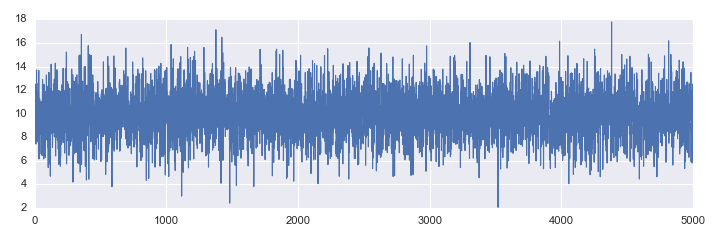

In [30]:
zs = [sense() for i in range(5000)]
with interactive_plot():
    plt.plot(zs, lw=1)

That looks like I would expect. The signal is centered around 10. A standard deviation of 2 means that 68% of the measurements will be within $\pm$ 2 of 10, and 99% will be within $\pm$ 6 of 10, and that looks like what is happening. 

Now let's look at a fat tailed distribution generated with the Student's $t$-distribution. I will not go into the math, but just give you the source code for it and then plot a distribution using it.

In [31]:
import random
import math

def rand_student_t(df, mu=0, std=1):
    """return random number distributed by Student's t 
    distribution with `df` degrees of freedom with the 
    specified mean and standard deviation.
    """
    x = random.gauss(0, std)
    y = 2.0*random.gammavariate(0.5*df, 2.0)
    return x / (math.sqrt(y / df)) + mu

<IPython.core.display.Javascript object>


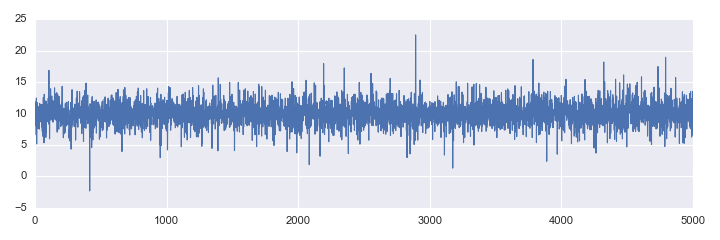

In [32]:
def sense_t():
    return 10 + rand_student_t(7)*2

zs = [sense_t() for i in range(5000)]
with interactive_plot():
    plt.plot(zs, lw=1)

We can see from the plot that while the output is similar to the normal distribution there are outliers that go far more than 3 standard deviations from the mean (7 to 13). This is what causes the 'fat tail'.

It is unlikely that the Student's $t$-distribution is an accurate model of how your sensor (say, a GPS or Doppler) performs, and this is not a book on how to model physical systems. However, it does produce reasonable data to test your filter's performance when presented with real world noise. We will be using distributions like these throughout the rest of the book in our simulations and tests. 

This is not an idle concern. The Kalman filter equations assume the noise is normally distributed, and perform sub-optimally if this is not true. Designers for mission critical filters, such as the filters on spacecraft, need to master a lot of theory and empirical knowledge about the performance of the sensors on their spacecraft. 

The code for rand_student_t is included in `filterpy.stats`. You may use it with

```python
from filterpy.stats import rand_student_t
```

## Summary and Key Points

This chapter is a poor introduction to statistics in general. I've only covered the concepts that  needed to use Gaussians in the remainder of the book, no more. What I've covered will not get you very far if you intend to read the Kalman filter literature. If this is a new topic to you I suggest reading a statistics textbook. I've always liked the Schaum series for self study, and Alan Downey's *Think Stats* [5] is also very good. 

The following points **must** be understood by you before we continue:

* Normals express a continuous probability distribution
* They are completely described by two parameters: the mean ($\mu$) and variance ($\sigma^2$)
* $\mu$ is the average of all possible values
* The variance $\sigma^2$ represents how much our measurements vary from the mean
* The standard deviation ($\sigma$) is the square root of the variance ($\sigma^2$)
* Many things in nature approximate a normal distribution

## References

[1] https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/Supporting_Notebooks/Computing_and_plotting_PDFs.ipynb

[2] http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

[3] http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html

[4] Huber, Peter J. *Robust Statistical Procedures*, Second Edition. Society for Industrial and Applied Mathematics, 1996.

[5] Downey, Alan. *Think Stats*, Second Edition. O'Reilly Media.

https://github.com/AllenDowney/ThinkStats2

http://greenteapress.com/thinkstats/